In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from VAE_OPTIMIZATION_WD import _dataset, VAE, study, compare_continuous, compare_integer#, compare_distributions_binned_aux, compare_distributions_binned

[I 2021-08-02 09:24:19,860] Using an existing study with name 'Optimizing the VAE with WD - BKG vs Random Sampling' instead of creating a new one.


## Loading the Study

In [2]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 100
Best trial:
  Value: 6.630528688507764
  Params: 
    alpha: 6561
    hidden_size: 28
    lr: 0.00043266173297886026
    n_layers_decoder: 12
    n_layers_encoder: 4
    n_units_decoder_l0: 265
    n_units_decoder_l1: 475
    n_units_decoder_l10: 285
    n_units_decoder_l11: 85
    n_units_decoder_l2: 325
    n_units_decoder_l3: 385
    n_units_decoder_l4: 215
    n_units_decoder_l5: 265
    n_units_decoder_l6: 445
    n_units_decoder_l7: 75
    n_units_decoder_l8: 405
    n_units_decoder_l9: 445
    n_units_encoder_l0: 190
    n_units_encoder_l1: 20
    n_units_encoder_l2: 480
    n_units_encoder_l3: 20
 TRIAL NUMBER: 83


### Optuna Graphs

In [3]:
optuna.visualization.plot_param_importances(study) 

In [4]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [5]:
# Nao é o 49, 53, 33, 26, 25, 23, 22, 16
#name = "wd-sample_vs_data_trial_16"
#name = "wd-sample_vs_data_trial_{}".format(trial.number)
name = f"CustomTrain_WD-Data_vs_Sampling_trial_{trial.number}"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[16], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=47, out_features=190, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=190, out_features=20, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=20, out_features=480, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=480, out_features=20, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=20, out_features=28, bias=True)
  )
  (hidden2mu): Linear(in_features=28, out_features=28, bias=True)
  (hidden2log_var): Linear(in_features=28, out_features=28, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=28, out_features=265, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=265, out_features=475, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=475, out_features=325, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=325, ou

### Load data

In [6]:
# Bkg
bkg = _dataset(category='test',variant='bkg').all_data()
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(334164, 47)

## Check if z ~ N(0,1)

In [7]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(334164, 28)

<ipython-input-8-cccee3f30eb4>:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



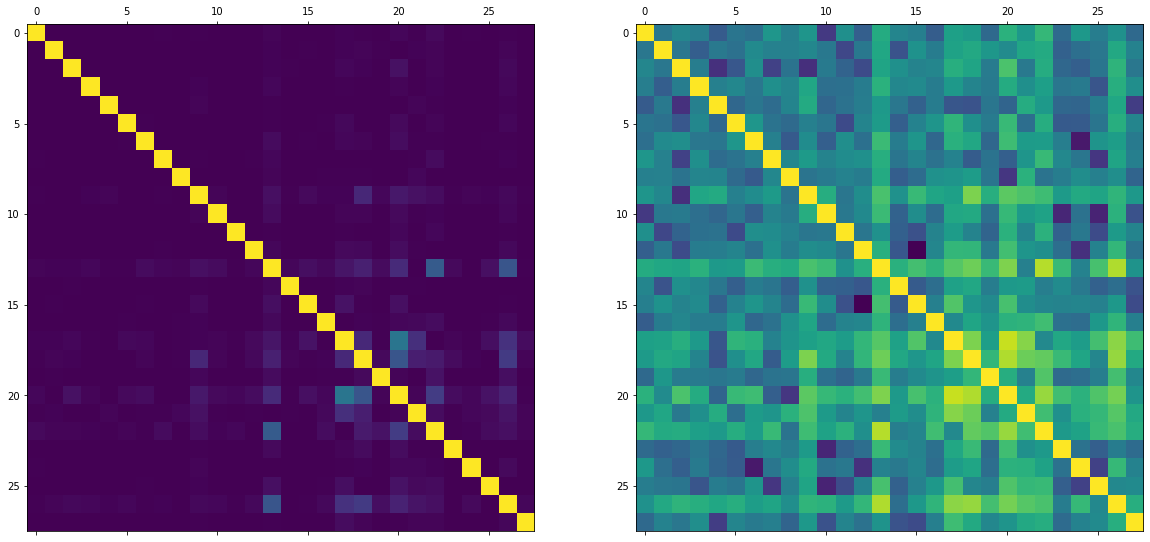

In [8]:
fig = plt.figure(figsize=[20,15])
i = 0

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs))

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs).apply(np.log))
fig.show()

In [9]:
corr = pd.DataFrame(hidden).corr().apply(abs)
corr.replace(1, 0, inplace=True)

print("Max:\t", round(corr.max().max(), 5))
print("Mean:\t", round(corr.mean().mean(), 5))

Max:	 0.38726
Mean:	 0.01365


Mean: -0.00014594763 	Std: 0.85412896
Mean: -0.005957157 	Std: 0.8363382
Mean: 0.0050811693 	Std: 0.8340739
Mean: 0.0037316028 	Std: 0.84721273
Mean: -0.009596399 	Std: 0.84501404
Mean: -0.005473581 	Std: 0.8277574
Mean: 0.0034153704 	Std: 0.85340065
Mean: 0.021342274 	Std: 0.8331738
Mean: -0.013797977 	Std: 0.8433007
Mean: -0.074515484 	Std: 0.9819368
Mean: -0.016899459 	Std: 0.8442591
Mean: -0.000420148 	Std: 0.84977907
Mean: 0.013370828 	Std: 0.81815636
Mean: 0.23215564 	Std: 1.2903435
Mean: 0.018461814 	Std: 0.841317
Mean: 0.0065646465 	Std: 0.8400478
Mean: 0.0049077207 	Std: 0.8333242
Mean: -0.05601475 	Std: 0.98556924
Mean: 0.19389501 	Std: 0.97740865
Mean: -0.013206257 	Std: 0.8256304
Mean: 0.21910356 	Std: 1.3059615
Mean: 0.0050377757 	Std: 0.97849977
Mean: -0.4747603 	Std: 1.5246313
Mean: 0.009828278 	Std: 0.8380235
Mean: -0.0074480507 	Std: 0.8329811
Mean: -0.0018561655 	Std: 0.8205954
Mean: -0.24121551 	Std: 1.4228075
Mean: -0.0009253728 	Std: 0.8520532


Total average mean 

<ipython-input-10-3e65db6d3c91>:20: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



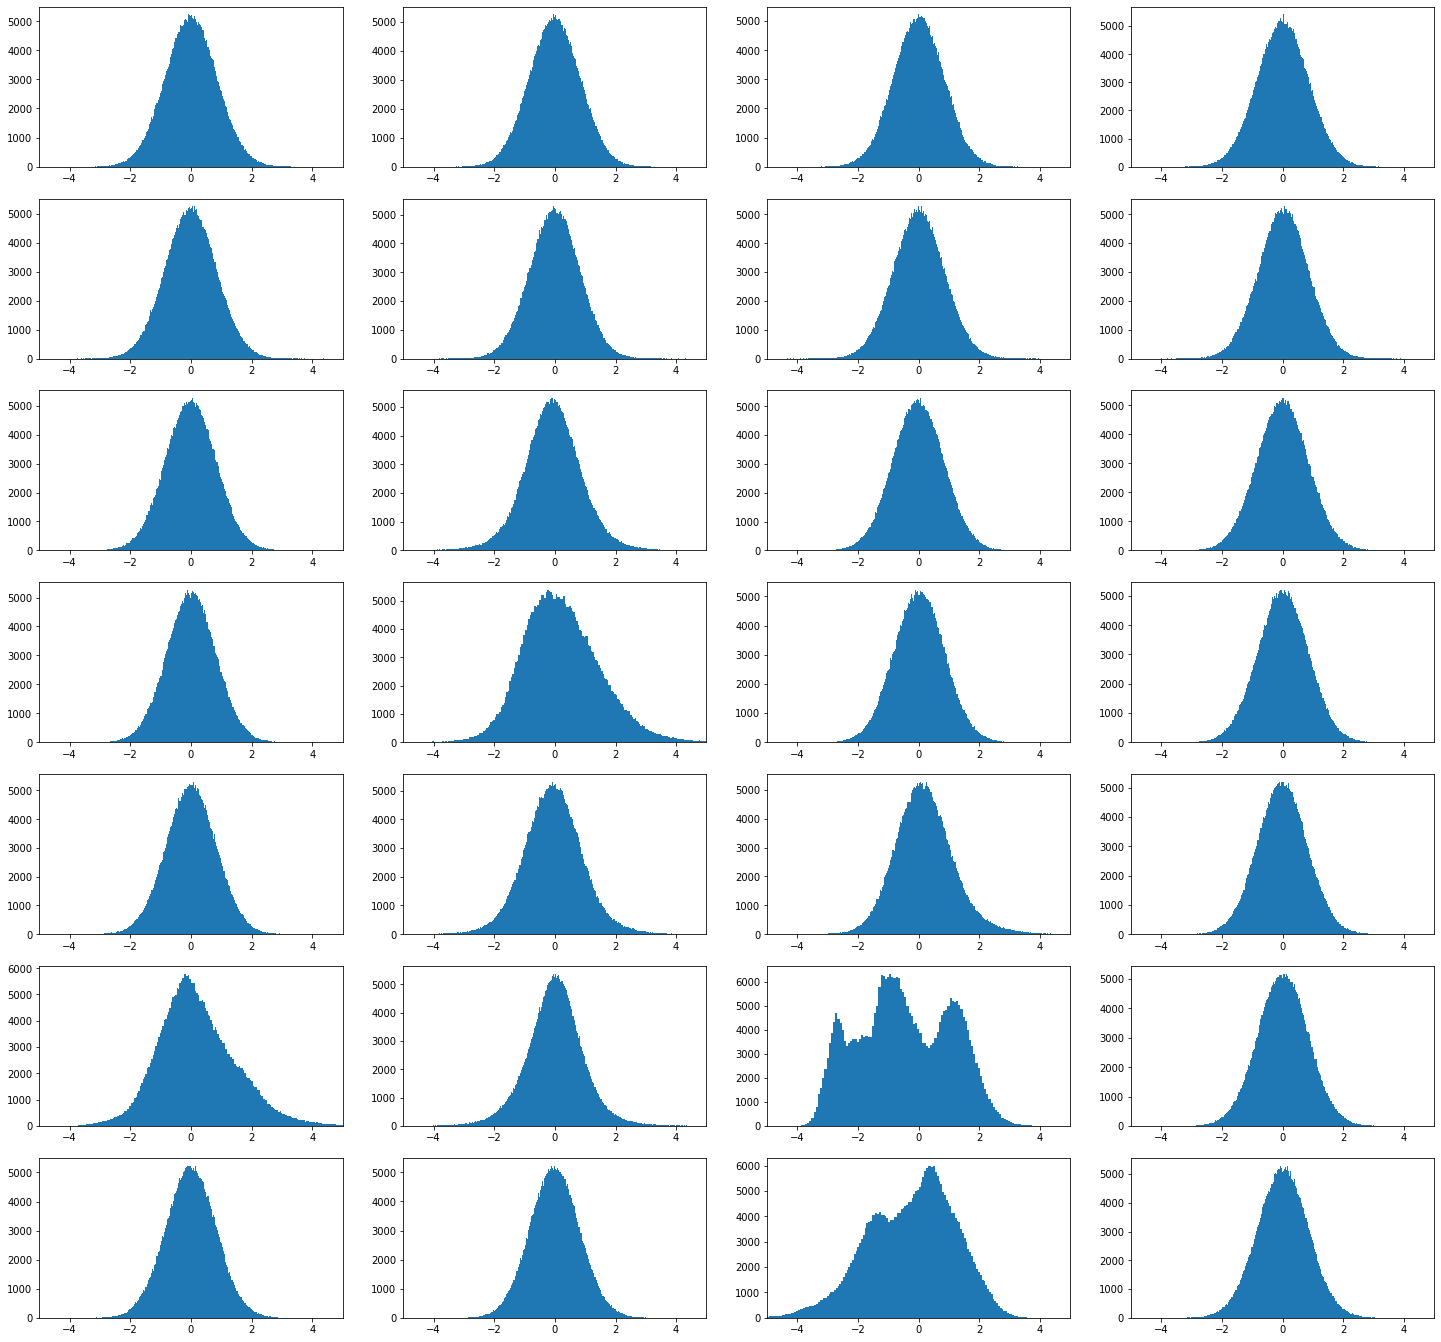

In [10]:

fig = plt.figure(figsize=[25,70])
i = 0

total_mean = []
total_std = []
for x in range(hidden.shape[1]):
    axes = fig.add_subplot(20,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    total_mean.append(hidden[:, x].mean())
    total_std.append(hidden[:, x].std())
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())

print("\n")
print("Total average mean", np.array(total_mean).mean())
print("Total average std", np.array(total_std).mean())
fig.show()

## Bkg Data vs Random Sampling Decoding

In [11]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,Lepton1_Eta,Lepton1_PT,Lepton1_Phi,Lepton2_Eta,Lepton2_PT,Lepton2_Phi,MissingET_MET,MissingET_Phi,Muon_Multi,ScalarHT_HT
count,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,...,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000,334164.000000
mean,-0.430429,-0.949907,0.577469,-0.367316,-0.130375,0.673236,-0.177425,-0.227173,-0.241255,-0.248001,...,-1.045747,-0.190191,-0.896728,-1.012957,0.156112,0.137338,0.142135,-0.387789,0.415720,-0.249228
std,0.568546,1.440207,0.519150,0.364470,0.939212,0.548002,0.352810,0.387639,0.397164,0.395938,...,1.291326,0.368105,0.329018,1.224975,0.502740,0.806345,0.496854,0.621456,0.567122,0.386646
min,-0.919850,-3.377238,-1.316074,-1.033543,-3.492681,-1.127468,-0.918185,-1.047976,-1.064751,-1.067254,...,-3.315413,-1.077219,-2.170691,-3.281788,-1.248126,-2.185785,-0.780970,-3.072501,-1.326818,-0.963755
25%,-0.859487,-2.171426,0.488537,-0.619464,-0.863581,0.576410,-0.423992,-0.500992,-0.525014,-0.533918,...,-2.110927,-0.451984,-1.097200,-2.027532,-0.234315,-0.359465,-0.207008,-0.803401,-0.238708,-0.523310
50%,-0.842049,-1.673447,0.661633,-0.475407,-0.277989,0.811797,-0.165079,-0.222297,-0.240242,-0.251534,...,-1.702996,-0.224023,-0.862686,-1.618716,0.075941,0.097241,0.030907,-0.394746,0.825386,-0.357865
75%,0.227164,0.465987,0.861076,-0.227880,0.822932,1.004947,0.075123,0.045316,0.034695,0.025984,...,0.244302,0.012542,-0.703578,0.218322,0.460380,0.795413,0.386748,0.020970,0.843690,-0.082563
max,1.312822,2.858433,2.118390,1.858780,1.807017,2.109593,2.048125,1.274336,1.336560,1.351553,...,2.004844,2.179505,1.313513,1.918301,3.287096,1.964574,4.113637,1.988556,0.908444,1.718952


In [12]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        #WD_SCORE += wasserstein_distance(background[x], signal[x])
        #R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()

Processing...:   0%|          | 0/47 [00:00<?, ?it/s]

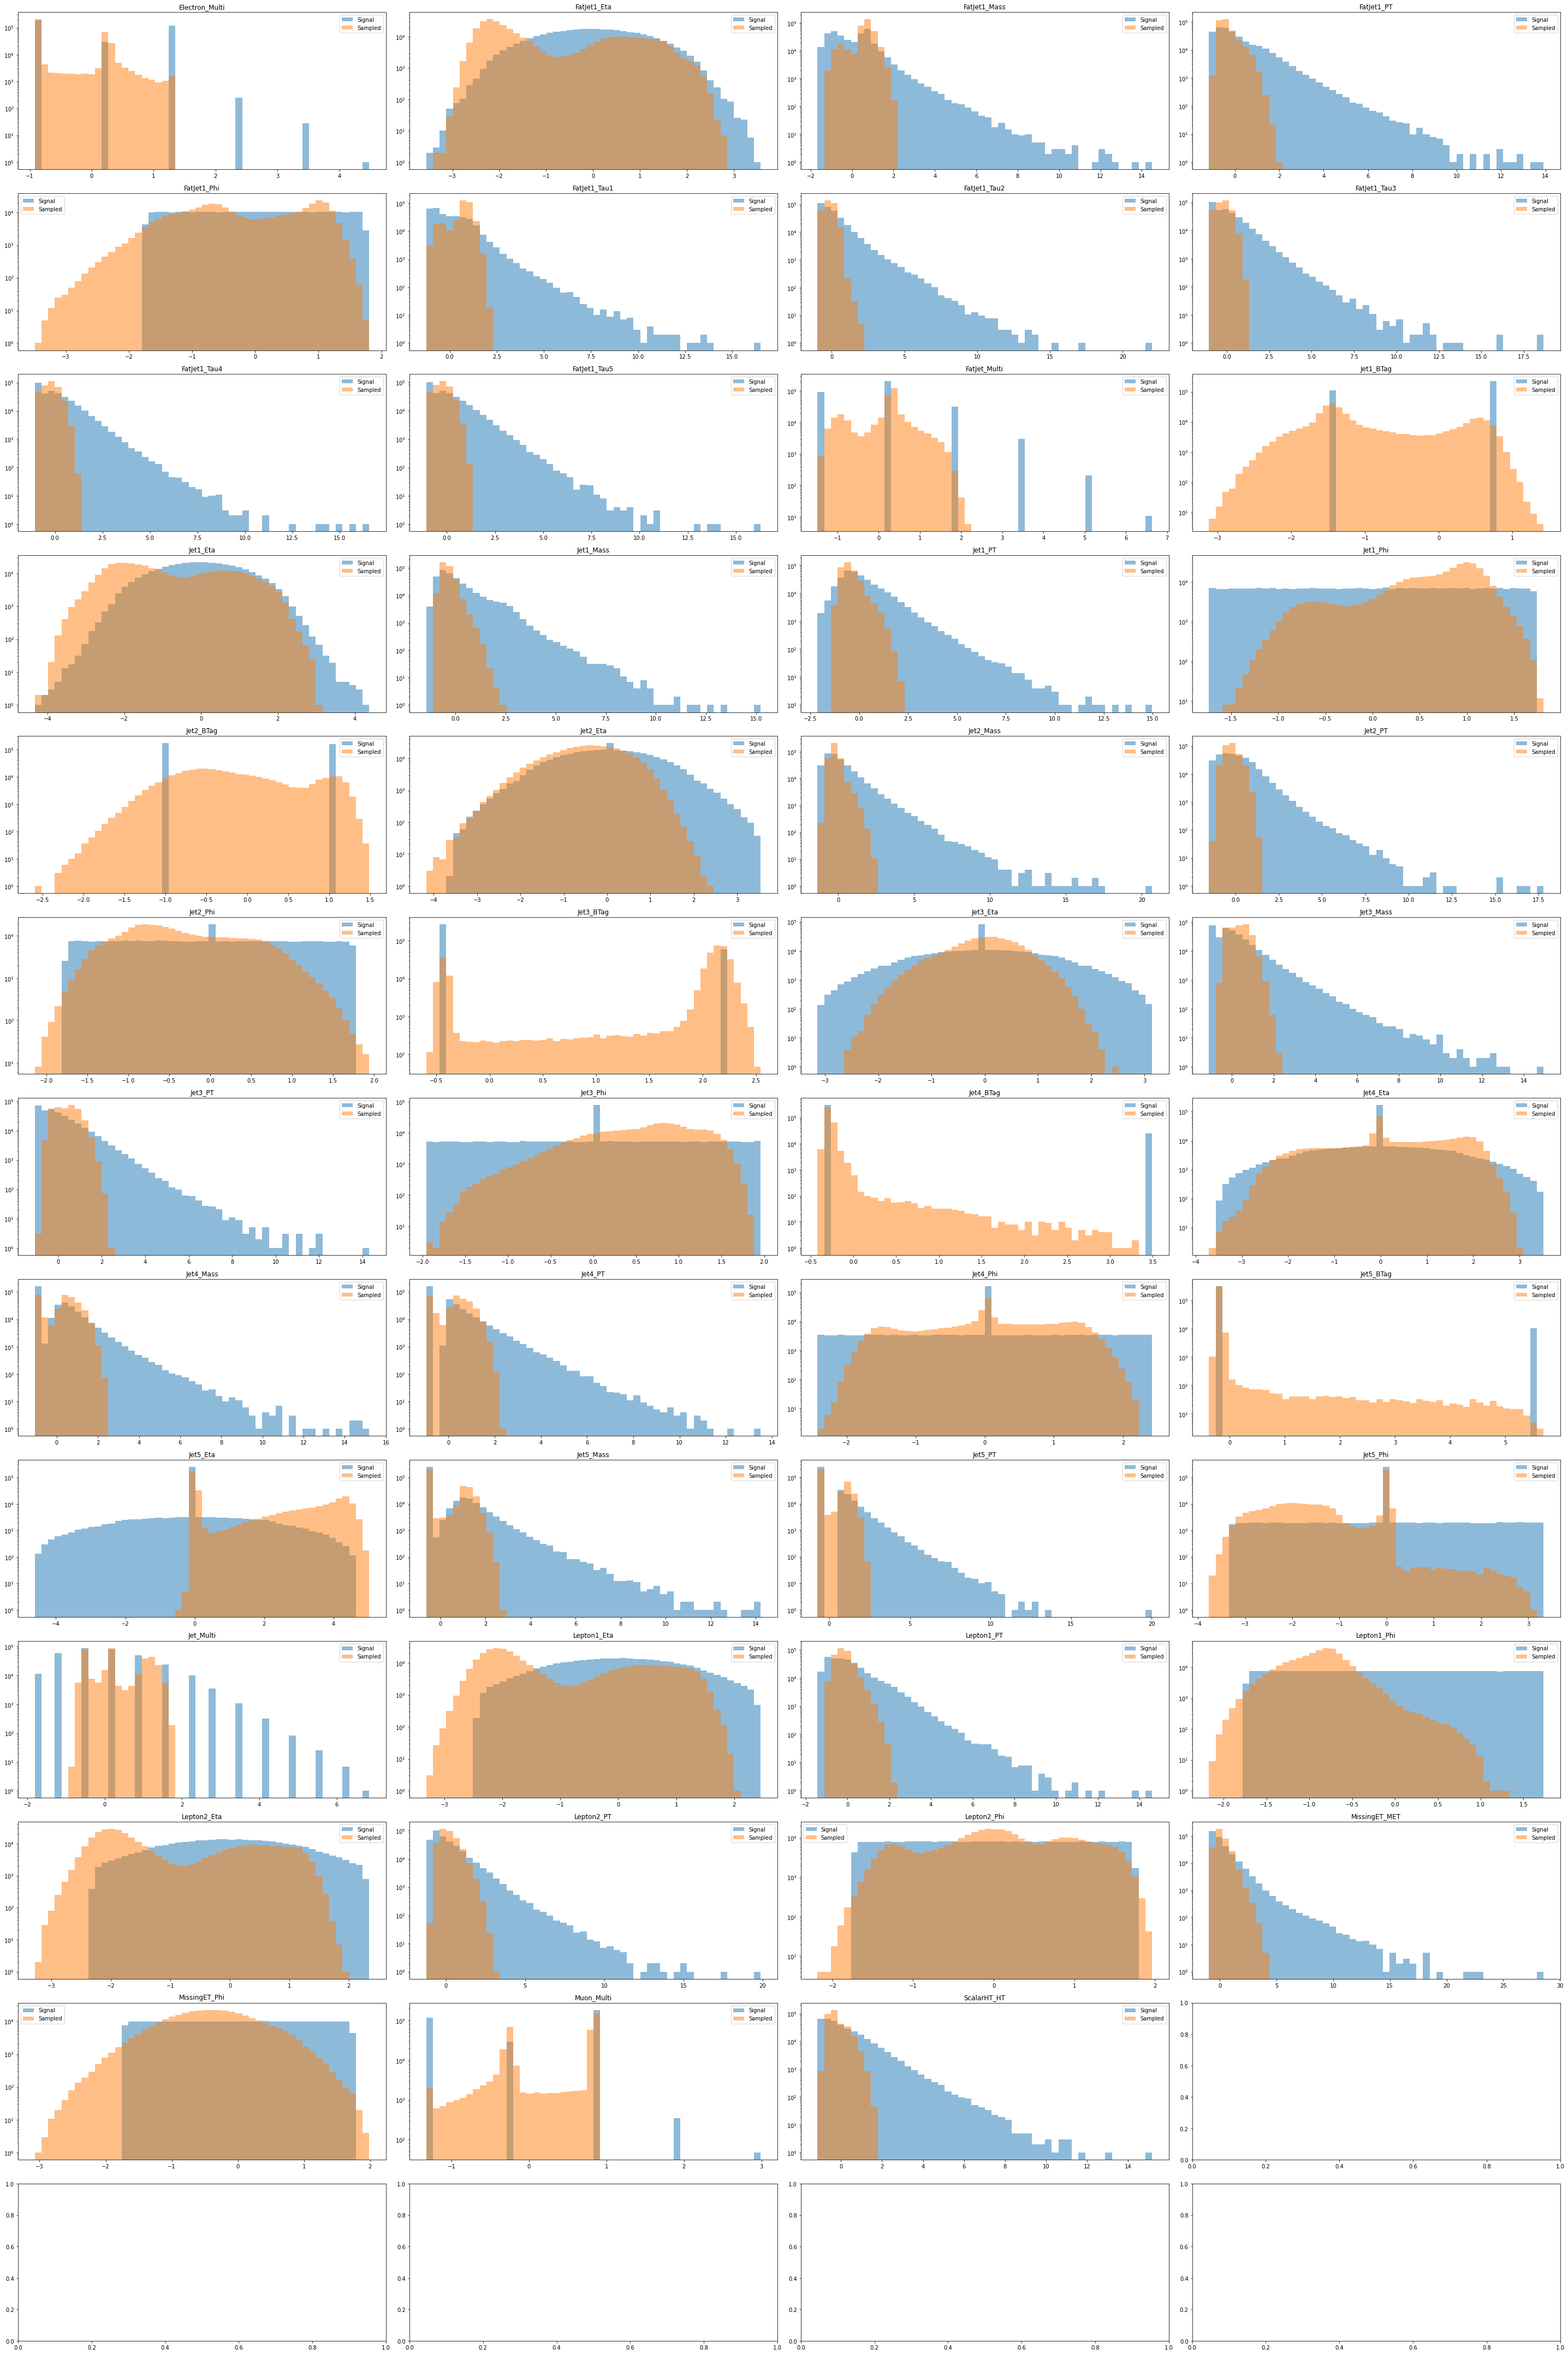

In [13]:
plot_graphs2(bkg, sample)

In [14]:
objective_score = 0
for idx in range(bkg.shape[1]):
    feature = bkg.columns[idx]
    if "Tag" in feature or "Multi" in feature:
        #print("Feature", feature, "é inteiro")
        objective_score += compare_integer(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
    else:
        #print("Feature", feature, "é continuo")
        objective_score += compare_continuous(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
print("WD Score:", objective_score)

WD Score: 6.718012167065744


## Bkg Data vs Reconstruction

In [15]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        #R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("R2_SCORE:", R2_SCORE/num_features)

Processing...:   0%|          | 0/47 [00:00<?, ?it/s]

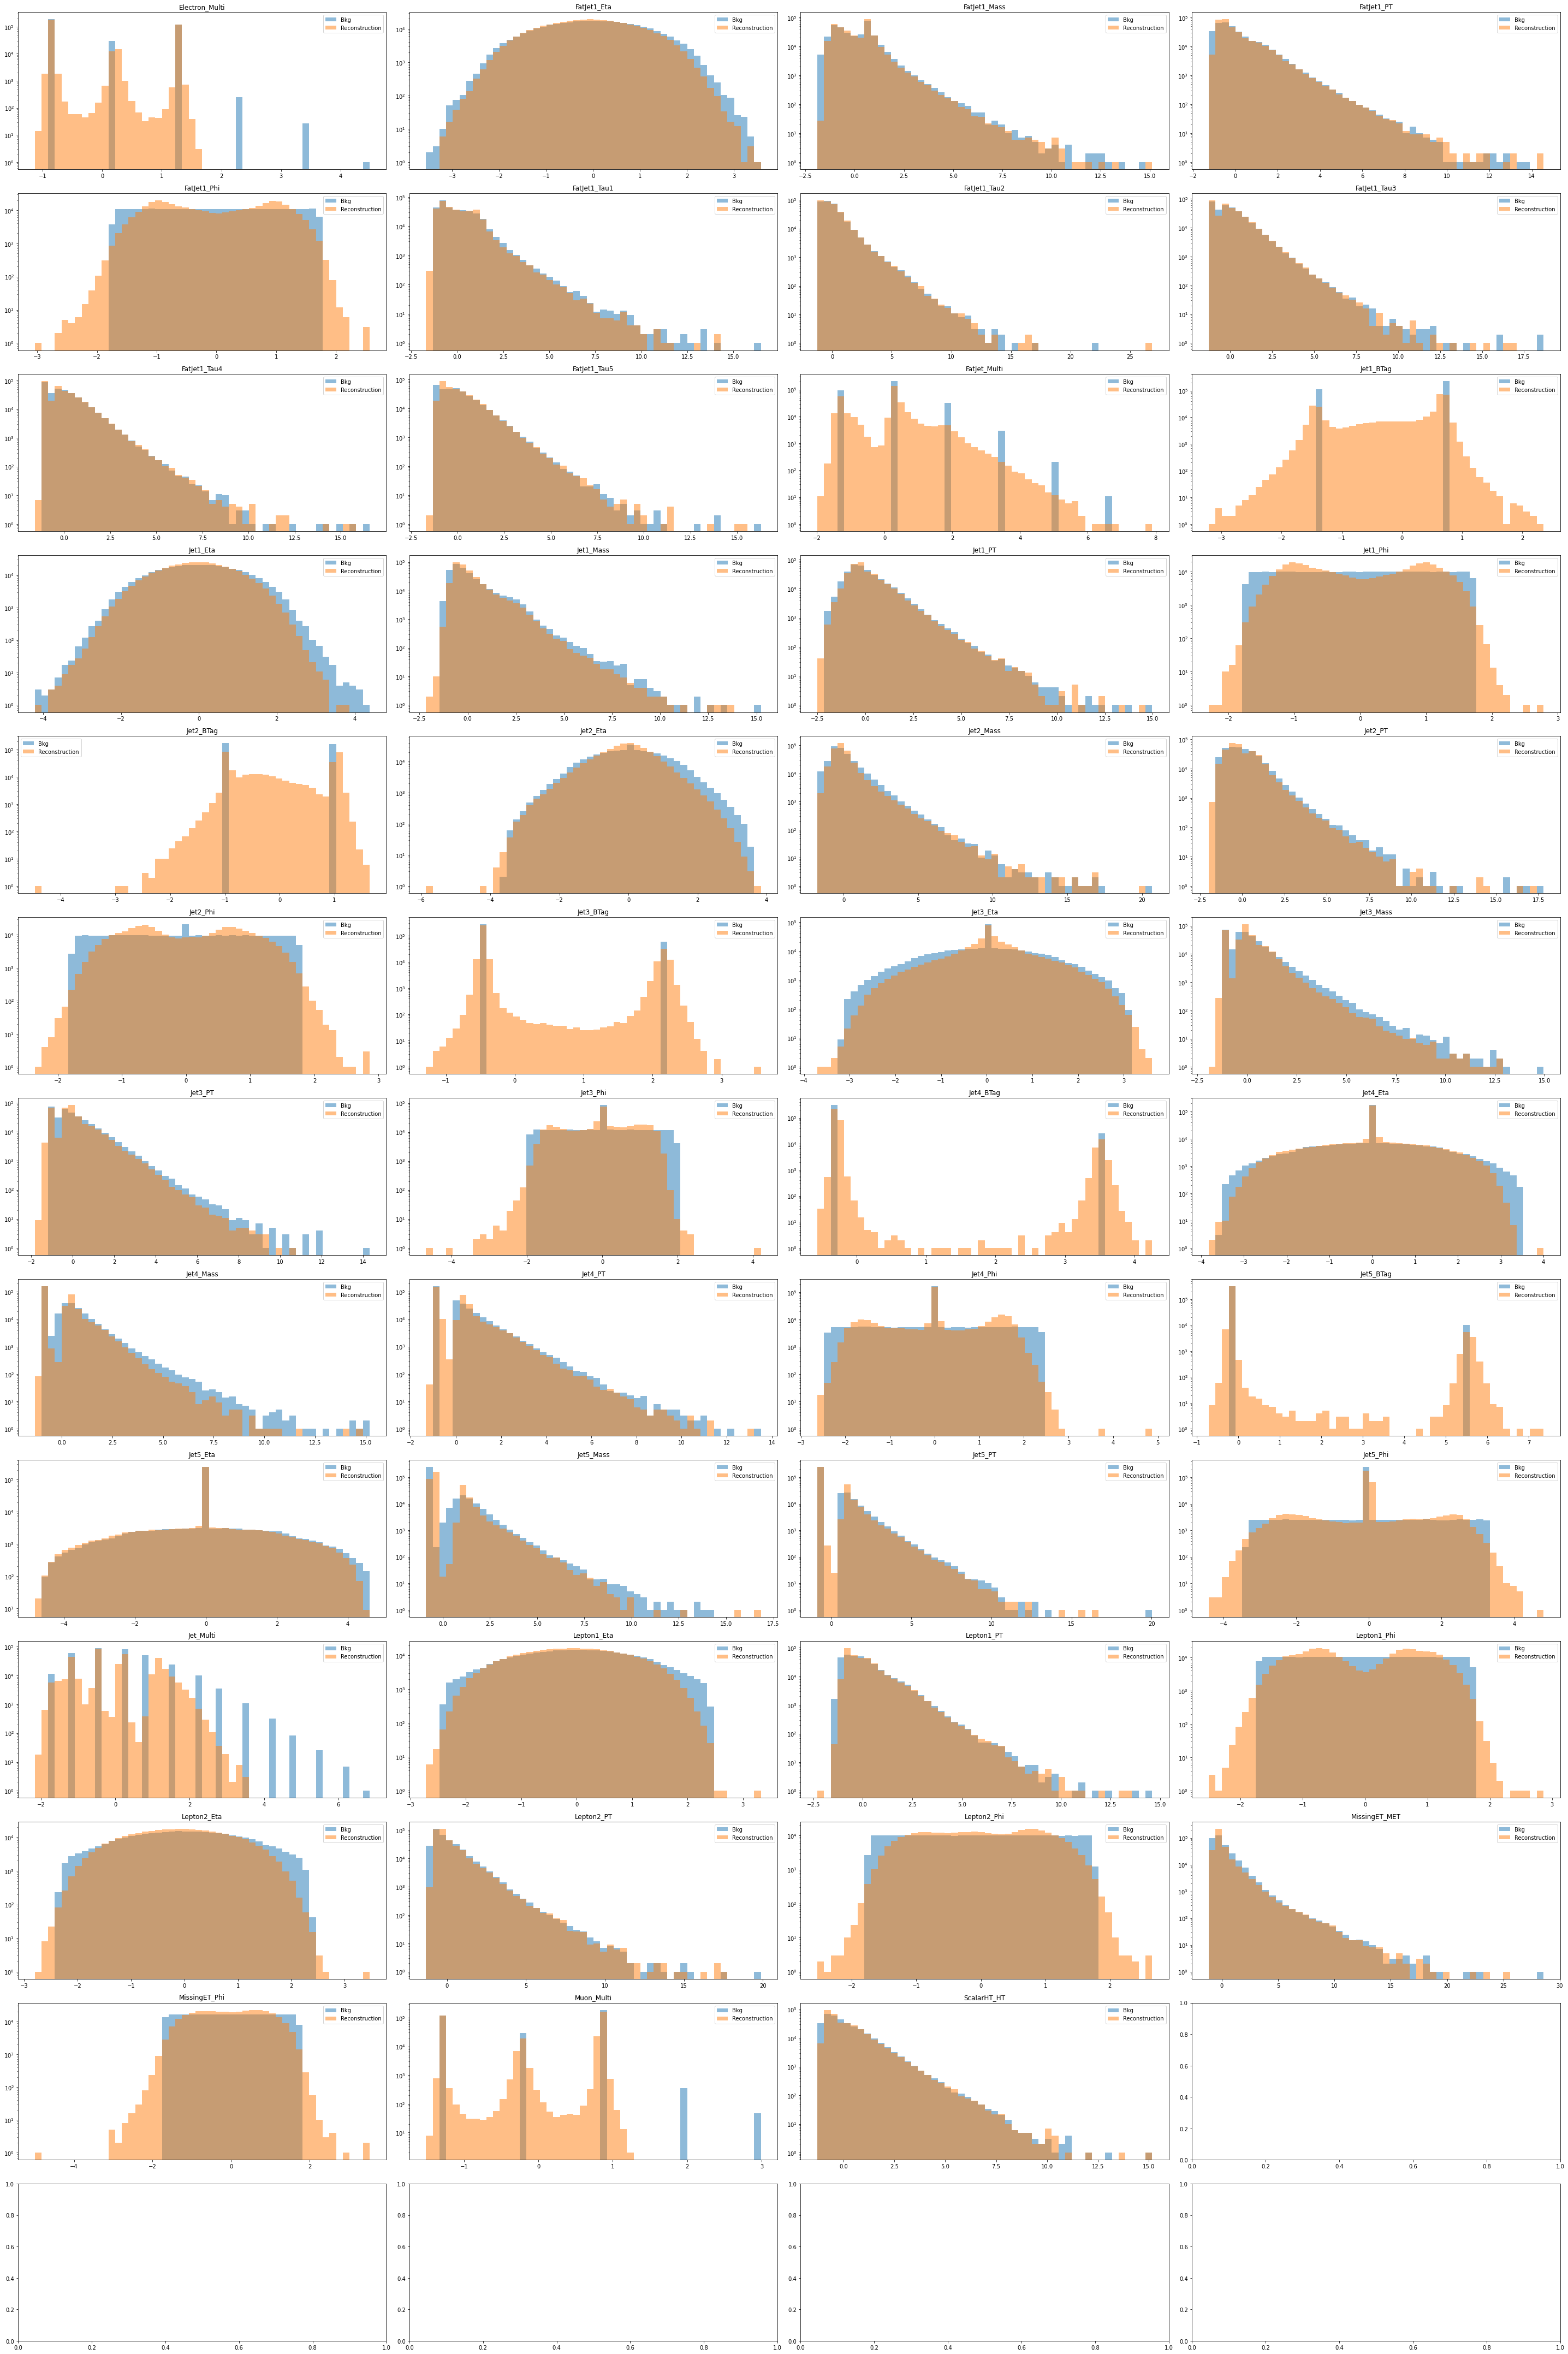

In [16]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

In [17]:
print("R2 Score:", r2_score(bkg.to_numpy(), x_out, sample_weight=bkg_weights.to_numpy()))

R2 Score: 0.8233274022124705


## Plot error distributions and ROC Scores

Load data

In [6]:
bkg = _dataset(category='test',variant='bkg').all_data()
signal = _dataset(category='all',variant='signal').all_data()
# signal.drop(columns=['weights'], inplace=True)

data = pd.concat([signal, bkg])
del signal, bkg

Plot

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,precision_score

def plot_graphs3(data, bins=50, num_cols=4):
    # Plot creation
    features = list(data['name'].unique())

    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        ## Get the relevant data
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        ## Pass input through model to get the output
        _, _, output, _ = model.test_step(sData)

        ## Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    ## Normalize the distributions
    # This way all values should be between 0 and 1

    # x transform
    min_of_dist = min(map(lambda x: min(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] - min_of_dist
    # scale
    max_of_dist = max(map(lambda x: max(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    
    ## Plot error distributions
    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2, density=True)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range, density=True)

    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    ## Plot ROC Curves
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            # Set Scores
            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 

            # Set weights
            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            # Get Curve
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            print(f"ROC SCORE for {x.replace('.h5', '')}:", 
                    roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights))
            #print(score.min(), score.max())
            #print(np.unique(np.rint(score)))
            print("Confusion matrix:")
            print(confusion_matrix(labels, np.rint(score)))
            print("\n")
    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

ROC SCORE for fcnc: 0.8289647435722736
Confusion matrix:
[[321576  12588]
 [ 72560  17518]]


ROC SCORE for hg3000_hq1400: 0.9858847049412001
Confusion matrix:
[[321576  12588]
 [  2462  23090]]


ROC SCORE for hg3000_hq1200: 0.9863899559413962
Confusion matrix:
[[321576  12588]
 [  2470  24084]]


ROC SCORE for wohg_hq1000: 0.986839138845434
Confusion matrix:
[[321576  12588]
 [  2439  25782]]


ROC SCORE for wohg_hq1200: 0.9860339499897852
Confusion matrix:
[[321576  12588]
 [  2538  23923]]


ROC SCORE for hg3000_hq1000: 0.9863981565731744
Confusion matrix:
[[321576  12588]
 [  2576  25603]]


ROC SCORE for wohg_hq1400: 0.9855472503817632
Confusion matrix:
[[321576  12588]
 [  2507  22650]]




<ipython-input-7-d46a204e70c1>:91: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



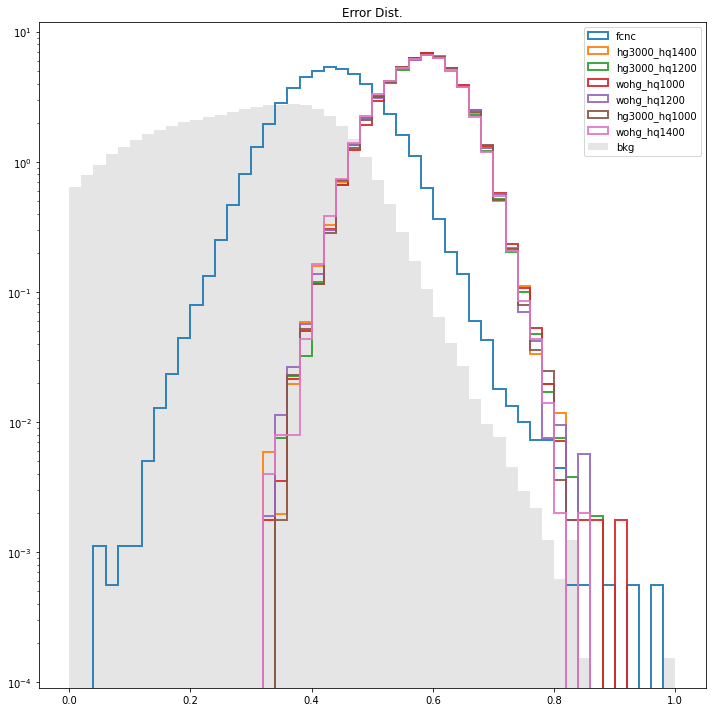

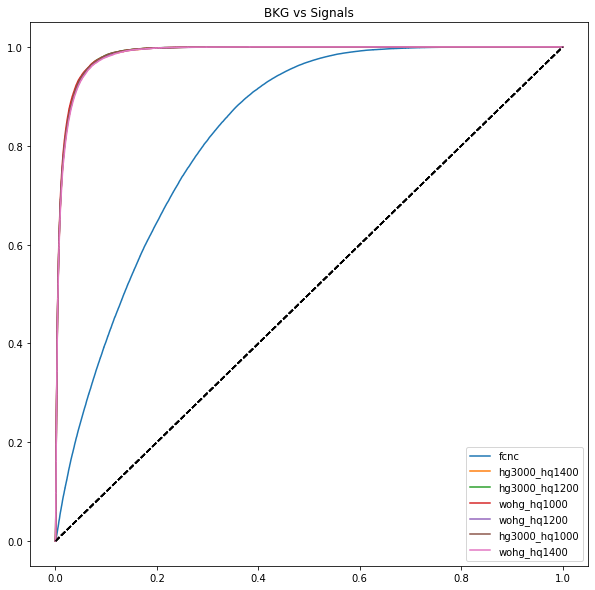

In [8]:
plot_graphs3(data)